In [1]:
import os, math, random, time, warnings, contextlib
from torch.amp import GradScaler, autocast
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns 
from functools import lru_cache
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms as T, models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import plotly.express as px
from torchvision.transforms.functional import to_pil_image


In [2]:
# Config & Paths 

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# CSVs and images
IMG_ROOT = "/kaggle/input/eurosat-dataset/EuroSAT"
# NOTE: keep your CSVs where your notebook expects them:
CSV_ROOT = "/kaggle/input/test-train-validation-csv"

TRAIN_CSV = "train.csv"
VAL_CSV   = "validation.csv"
TEST_CSV  = "test.csv"

# Image & pretrain hyperparams 
IMG_SIZE = 224
BATCH_SIZE_PRETRAIN = 64
EPOCHS_PRETRAIN = 100
LR_PRETRAIN = 3e-4
PROJ_DIM = 128
TEMP = 0.2  

# Linear eval hyperparams 
BATCH_SIZE_LINEAR = 64
EPOCHS_LINEAR = 100
LR_LINEAR = 1e-3
PATIENCE = 10

BATCH_PRE = BATCH_SIZE_PRETRAIN
EPOCHS_PRE = EPOCHS_PRETRAIN
LR_PRE = LR_PRETRAIN

BATCH_LIN = BATCH_SIZE_LINEAR
EPOCHS_LIN = EPOCHS_LINEAR
LR_LIN = LR_LINEAR

print("Device:", DEVICE)
print(f"Device: {DEVICE.type}")
print(f"IMG_ROOT: {IMG_ROOT}")
print(f"CSV_ROOT: {CSV_ROOT}")
print(f"Splits: {TRAIN_CSV} {VAL_CSV} {TEST_CSV}")
print(f"IMG_SIZE={IMG_SIZE}  BATCH_PRE={BATCH_PRE}  EPOCHS_PRE={EPOCHS_PRE}  LR_PRE={LR_PRE}  TEMP={TEMP}")
print(f"BATCH_LIN={BATCH_LIN}  EPOCHS_LIN={EPOCHS_LIN}  LR_LIN={LR_LIN}  PATIENCE={PATIENCE}  PROJ_DIM={PROJ_DIM}")

# Speed knobs (kept from your original)
try:
    torch.backends.cudnn.benchmark = True
except Exception:
    pass
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
except Exception:
    pass

Device: cuda
Device: cuda
IMG_ROOT: /kaggle/input/eurosat-dataset/EuroSAT
CSV_ROOT: /kaggle/input/test-train-validation-csv
Splits: train.csv validation.csv test.csv
IMG_SIZE=224  BATCH_PRE=64  EPOCHS_PRE=100  LR_PRE=0.0003  TEMP=0.2
BATCH_LIN=64  EPOCHS_LIN=100  LR_LIN=0.001  PATIENCE=10  PROJ_DIM=128


In [3]:
# CSV Loading 

PATH_COL_ENV  = os.environ.get("PATH_COL_NAME", "").strip()
LABEL_COL_ENV = os.environ.get("LABEL_COL_NAME", "").strip()  # not used for final labels (we map by folder)
EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp", ".gif")

def _pick_col(df, candidates):
    lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand in df.columns:
            return cand
        if cand.lower() in lower:
            return lower[cand.lower()]
    return None

def _looks_like_filename(s: str) -> bool:
    s = str(s).strip().lower()
    if not s:
        return False
    for ext in EXTS:
        if s.endswith(ext):
            return True
    return False

def _fix_one_path(p, img_root):
    p = str(p).strip()
    if os.path.exists(p):
        return p
    p2 = os.path.join(img_root, p)
    if os.path.exists(p2):
        return p2
    # try removing leading ./ and rejoin
    p3 = p.lstrip("./")
    p3 = os.path.join(img_root, p3)
    return p3  # PIL will raise later if invalid; useful to catch bad rows

def load_split(csv_root, csv_name, img_root):
    csv_path = os.path.join(csv_root, csv_name)
    df = pd.read_csv(csv_path)

    # 1) Choose the image path column (env override → common names → folder+filename → heuristic)
    pcol = PATH_COL_ENV if (PATH_COL_ENV and PATH_COL_ENV in df.columns) else None
    if pcol is None:
        pcol = _pick_col(df, [
            "path","image","filepath","file","img",
            "filename","file_name","image_name","imagepath","image_path",
            "Image","ImageID","img_path"
        ])

    if pcol is None:
        folder_col = _pick_col(df, ["folder","dir","directory","class_dir","parent"])
        file_col   = _pick_col(df, ["filename","file_name","file","image","img","image_name"])
        if folder_col is not None and file_col is not None:
            df["__path__"] = df[folder_col].astype(str).str.rstrip("/\\") + "/" + df[file_col].astype(str).str.lstrip("/\\")
            pcol = "__path__"

    if pcol is None:
        # heuristic: pick a column whose values look like filenames (check up to 50 rows without slicing)
        chosen = None
        total = min(len(df), 50)
        for col in df.columns:
            cnt = 0
            checked = 0
            for val in df[col].astype(str):
                if _looks_like_filename(val):
                    cnt += 1
                checked += 1
                if checked >= total:
                    break
            if checked > 0 and (cnt / float(checked)) >= 0.6:
                chosen = col
                break
        pcol = chosen

    if pcol is None:
        raise ValueError(
            f"Image path column not found in {csv_name}. "
            f"Columns present: {list(df.columns)}. "
            f'If needed, set os.environ["PATH_COL_NAME"]="your_image_column".'
        )

    # Build output with normalized paths
    out = pd.DataFrame()
    out["path"] = df[pcol].astype(str).apply(lambda p: _fix_one_path(p, img_root))

    print(
        f"Loaded {csv_name} — shape={out.shape} | path_col='{pcol}'\n"
        f"Head:\n{out.head(3)}"
    )
    return out

# Read splits
train_df = load_split(CSV_ROOT, TRAIN_CSV, IMG_ROOT)
val_df   = load_split(CSV_ROOT, VAL_CSV,   IMG_ROOT)
test_df  = load_split(CSV_ROOT, TEST_CSV,  IMG_ROOT)

def _class_name_from_path(p):
    return os.path.basename(os.path.dirname(str(p)))

all_names = pd.concat([
    train_df["path"].map(_class_name_from_path),
    val_df["path"].map(_class_name_from_path),
    test_df["path"].map(_class_name_from_path)
], axis=0)

classes = {name: i for i, name in enumerate(sorted(all_names.unique()))}

for df_ in (train_df, val_df, test_df):
    df_["label"] = df_["path"].map(lambda p: classes[_class_name_from_path(p)]).astype(int)

num_classes = len(classes)
print(f"Classes: {num_classes} | Class map example: {dict(list(classes.items())[:5])}")

Loaded train.csv — shape=(18900, 1) | path_col='Filename'
Head:
                                                path
0  /kaggle/input/eurosat-dataset/EuroSAT/AnnualCr...
1  /kaggle/input/eurosat-dataset/EuroSAT/Herbaceo...
2  /kaggle/input/eurosat-dataset/EuroSAT/Permanen...
Loaded validation.csv — shape=(5400, 1) | path_col='Filename'
Head:
                                                path
0  /kaggle/input/eurosat-dataset/EuroSAT/Pasture/...
1  /kaggle/input/eurosat-dataset/EuroSAT/Forest/F...
2  /kaggle/input/eurosat-dataset/EuroSAT/Highway/...
Loaded test.csv — shape=(2700, 1) | path_col='Filename'
Head:
                                                path
0  /kaggle/input/eurosat-dataset/EuroSAT/AnnualCr...
1  /kaggle/input/eurosat-dataset/EuroSAT/Resident...
2  /kaggle/input/eurosat-dataset/EuroSAT/Pasture/...
Classes: 10 | Class map example: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4}


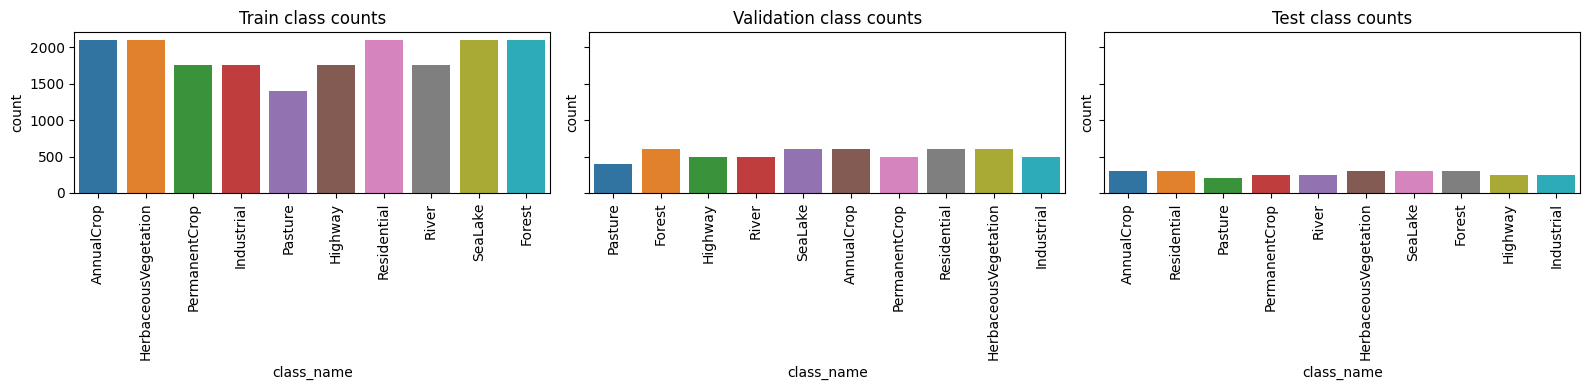

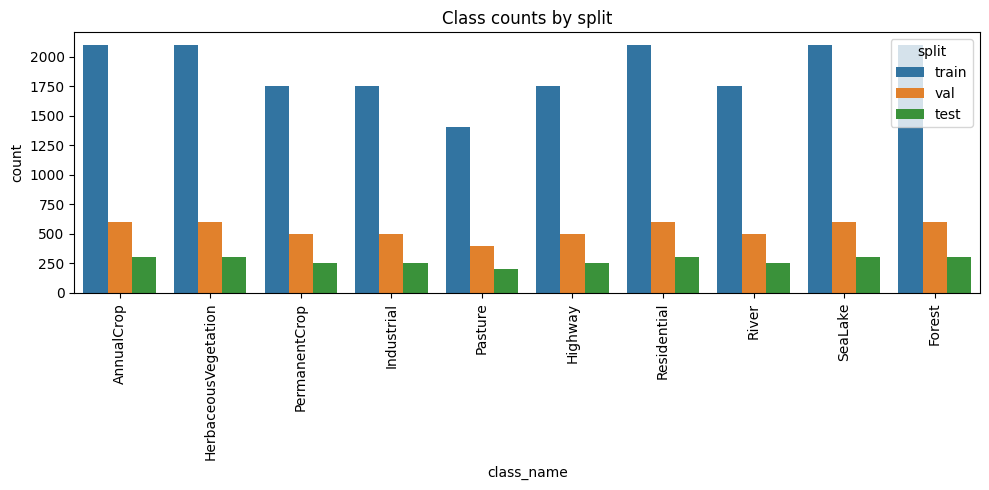

In [4]:
# Count plots: class distribution in train/val/test

# Map numeric labels → class names
id2name = {v:k for k,v in classes.items()}
for df_ in (train_df, val_df, test_df):
    df_["class_name"] = df_["label"].map(id2name)

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.countplot(data=train_df, x="class_name", ax=axes[0])
axes[0].set_title("Train class counts"); axes[0].tick_params(axis='x', rotation=90)

sns.countplot(data=val_df, x="class_name", ax=axes[1])
axes[1].set_title("Validation class counts"); axes[1].tick_params(axis='x', rotation=90)

sns.countplot(data=test_df, x="class_name", ax=axes[2])
axes[2].set_title("Test class counts"); axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout(); plt.show()

# (Optional) Combined stacked look by melt + bar (quick view)
train_df["split"]="train"; val_df["split"]="val"; test_df["split"]="test"
all_df = pd.concat([train_df[["class_name","split"]],
                    val_df[["class_name","split"]],
                    test_df[["class_name","split"]]], ignore_index=True)

plt.figure(figsize=(10,5))
sns.countplot(data=all_df, x="class_name", hue="split")
plt.title("Class counts by split"); plt.xticks(rotation=90); plt.tight_layout(); plt.show()

In [5]:
# Datasets & DataLoaders

def auto_workers():
    cpu = os.cpu_count() or 4
    return max(4, min(12, cpu))  # more workers to feed GPU

# SimCLR augmentations (same flavor, cheaper on CPU)
IMG_SIZE = int(IMG_SIZE)  # keep 224
k = 7  # smaller blur kernel

base_aug = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.35, 1.0)),   # fewer extreme resizes than (0.2,1.0)
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.3, 0.3, 0.3, 0.1)], p=0.5),  # lighter & less frequent than p=0.8
    T.RandomGrayscale(p=0.08),                                  # was 0.2
    T.RandomApply([T.GaussianBlur(kernel_size=k, sigma=(0.1, 1.0))], p=0.25),  # not every sample
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

class PairTransform:
    def __init__(self, base_tf): self.base_tf = base_tf
    def __call__(self, img):
        return self.base_tf(img), self.base_tf(img)

train_transform = PairTransform(base_aug)

eval_transform  = T.Compose([
    T.Resize(IMG_SIZE),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Cache decoded images in RAM (speeds up from epoch 2+)
@lru_cache(maxsize=100000)
def _load_rgb(path: str):
    return Image.open(path).convert("RGB")

class PairDataset(Dataset):
    def __init__(self, df, transform, cache=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.cache = cache
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = _load_rgb(row["path"]) if self.cache else Image.open(row["path"]).convert("RGB")
        x1, x2 = self.transform(img)
        return x1, x2

class ImageDataset(Dataset):
    def __init__(self, df, transform, cache=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.cache = cache
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = _load_rgb(row["path"]) if self.cache else Image.open(row["path"]).convert("RGB")
        x = self.transform(img)
        y = int(row["label"])
        return x, y

COMMON = dict(
    num_workers=auto_workers(),
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)

# Pairwise loader for pretext
train_pair_loader = DataLoader(
    PairDataset(train_df, train_transform, cache=True),
    batch_size=BATCH_PRE,
    shuffle=True, drop_last=True,
    **COMMON
)

# val_pair_loader (SimCLR-style pairs for validation)
val_pair_loader = DataLoader(
    PairDataset(val_df, train_transform, cache=True),  
    batch_size=BATCH_PRE,
    shuffle=False, drop_last=False,
    **COMMON
)

# Standard loaders for linear eval / features
train_cls_loader = DataLoader(
    ImageDataset(train_df, eval_transform, cache=True),
    batch_size=BATCH_LIN,
    shuffle=True,
    **COMMON
)
val_cls_loader = DataLoader(
    ImageDataset(val_df, eval_transform, cache=True),
    batch_size=BATCH_LIN,
    shuffle=False,
    **COMMON
)
test_cls_loader = DataLoader(
    ImageDataset(test_df, eval_transform, cache=True),
    batch_size=BATCH_LIN,
    shuffle=False,
    **COMMON
)

In [6]:
# Model: DenseNet-121 backbone as encoder with an MLP projection head for SimCLR
def build_encoder(pretrained=False):
    try:
        weights = (
            torchvision.models.DenseNet121_Weights.IMAGENET1K_V1
            if pretrained else None
        )
        model = torchvision.models.densenet121(weights=weights)
    except AttributeError:
        model = torchvision.models.densenet121(pretrained=pretrained)

    feat_dim = model.classifier.in_features
    model.classifier = torch.nn.Identity()
    return model, feat_dim

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim=128, hidden=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(inplace=True),
            nn.Linear(hidden, proj_dim)
        )
    def forward(self, x): 
        return self.net(x)

encoder, FEAT_DIM = build_encoder(pretrained=False)
proj_head = ProjectionHead(FEAT_DIM, proj_dim=PROJ_DIM).to(DEVICE)
encoder = encoder.to(DEVICE).to(memory_format=torch.channels_last)

params = list(encoder.parameters()) + list(proj_head.parameters())


In [7]:
# Contrastive Loss (NT-Xent) 

def _l2norm(x, eps=1e-8):
    # no @torch.no_grad() here — keep graph so gradients flow
    return x / (x.norm(p=2, dim=1, keepdim=True) + eps)

def nt_xent(z1, z2, temp=0.2):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    B  = z1.size(0)
    Z  = torch.cat([z1, z2], dim=0)           # [2B, D]
    sim = (Z @ Z.t()) / temp                  # [2B, 2B]
    sim.fill_diagonal_(float('-inf'))         # mask self
    idx = torch.arange(B, device=sim.device)
    pos_idx = torch.cat([idx + B, idx], dim=0)
    pos_sim = sim[torch.arange(2*B, device=sim.device), pos_idx].unsqueeze(1)
    sim.scatter_(1, pos_idx.view(-1,1), float('-inf'))  # mask positives in-place
    logits = torch.cat([pos_sim, sim], dim=1)
    labels = torch.zeros(2*B, dtype=torch.long, device=sim.device)
    return F.cross_entropy(logits, labels)

In [8]:
# Optional torch.compile 
USE_COMPILE = False
if torch.cuda.is_available() and hasattr(torch, "compile"):
    major, _ = torch.cuda.get_device_capability()
    USE_COMPILE = major >= 7
if USE_COMPILE:
    try:
        encoder = torch.compile(encoder)
        proj_head = torch.compile(proj_head)
        print("[compile] enabled")
    except Exception as e:
        print("[compile] disabled:", e)

In [9]:
# AMP (new API)
USE_AMP = (DEVICE.type == "cuda")
scaler  = GradScaler("cuda", enabled=USE_AMP)

def AMP():
    return autocast("cuda", dtype=torch.float16, enabled=USE_AMP)

In [10]:
# Pretraining — setup

warnings.filterwarnings("ignore", message=r".lr_scheduler\.step.*optimizer\.step.")

# knobs
LR = LR_PRE if 'LR_PRE' in globals() else (LR_PRETRAIN if 'LR_PRETRAIN' in globals() else 3e-4)
WARMUP_FRAC = WARMUP_FRAC if 'WARMUP_FRAC' in globals() else 0.10
WEIGHT_DECAY = 1e-4
VAL_EVERY = 2

# checkpoint paths (load from dataset; save to working dir)
CKPT_LOAD_DIR = Path("/kaggle/input/simclr-ckpts-v300")
LAST_PRE_PATH_LOAD       = str(CKPT_LOAD_DIR / "simclr_pretrain_last.pth")
BEST_PRETRAIN_FULL_LOAD  = str(CKPT_LOAD_DIR / "simclr_pretrain_best_full.pth")

CKPT_SAVE_DIR = Path("/kaggle/working/simclr_ckpt_500"); CKPT_SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_ENC_PATH            = str(CKPT_SAVE_DIR / "simclr_encoder_best.pth")
BEST_PRETRAIN_FULL_PATH  = str(CKPT_SAVE_DIR / "simclr_pretrain_best_full.pth")
LAST_PRE_PATH_SAVE       = str(CKPT_SAVE_DIR / "simclr_pretrain_last.pth")

# Prefer resuming from the current run's working dir if files exist
CANDIDATE_LOADS = [
    Path(LAST_PRE_PATH_SAVE),        # /kaggle/working/.../simclr_pretrain_last.pth
    Path(BEST_PRETRAIN_FULL_PATH),   # /kaggle/working/.../simclr_pretrain_best_full.pth
    Path(LAST_PRE_PATH_LOAD),        # /kaggle/input/.../simclr_pretrain_last.pth
    Path(BEST_PRETRAIN_FULL_LOAD),   # /kaggle/input/.../simclr_pretrain_best_full.pth
]

# Checkpoint helpers 
def _atomic_save(obj, path):
    p = Path(path); tmp = p.with_suffix(p.suffix + ".tmp")
    torch.save(obj, tmp); os.replace(tmp, p)   # atomic write

GLOBAL_STEP = GLOBAL_STEP if 'GLOBAL_STEP' in globals() else 0  # optional; increment in train loop if you want

def _pack_state(epoch):
    return {
        "encoder":   encoder.state_dict(),
        "proj_head": proj_head.state_dict(),
        "optimizer": opt.state_dict()        if 'opt' in globals() else None,
        "scheduler": scheduler.state_dict()  if 'scheduler' in globals() and scheduler is not None else None,
        "scaler":    scaler.state_dict()     if 'scaler' in globals() and scaler is not None else None,
        "hist": hist,
        "epoch": int(epoch),
        "best_val": float(best_val),
        "global_step": int(GLOBAL_STEP),
    }

def save_last(epoch):
    _atomic_save(_pack_state(epoch), LAST_PRE_PATH_SAVE)

def save_best_full(epoch):
    st = _pack_state(epoch)
    _atomic_save(st, BEST_PRETRAIN_FULL_PATH)
    _atomic_save({"encoder": encoder.state_dict()}, BEST_ENC_PATH)


# Resume flag 
os.environ["RESUME_PRETRAIN"] = "1"
RESUME_PRETRAIN = bool(int(os.environ.get("RESUME_PRETRAIN", "0")))

# optimizer (create if you didn't define one elsewhere)
opt = optimizer if 'optimizer' in globals() else torch.optim.AdamW(
    list(encoder.parameters()) + list(proj_head.parameters()),
    lr=LR, weight_decay=WEIGHT_DECAY
)

# cosine LR with warmup (per-step)
steps_per_epoch = max(1, len(train_pair_loader))
TOTAL_STEPS  = (EPOCHS_PRE if 'EPOCHS_PRE' in globals() else EPOCHS_PRETRAIN) * steps_per_epoch
WARMUP_STEPS = max(1, int(WARMUP_FRAC * TOTAL_STEPS))
def lr_lambda(step):
    if step < WARMUP_STEPS:
        return (step + 1) / float(WARMUP_STEPS)
    t = (step - WARMUP_STEPS) / max(1, (TOTAL_STEPS - WARMUP_STEPS))
    return 0.5 * (1.0 + math.cos(math.pi * t))
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)

# Resume (robust)
hist = hist if 'hist' in globals() else {"epoch": [], "train_loss": [], "val_loss": []}
best_val = best_val if 'best_val' in globals() else float("inf")
start_epoch = start_epoch if 'start_epoch' in globals() else 1

def _safe_load_scheduler(ck):
    if 'scheduler' in globals() and scheduler is not None:
        if ck.get("scheduler") is not None:
            try:
                scheduler.load_state_dict(ck["scheduler"]); print("↪ loaded scheduler state")
                return
            except Exception as e:
                print("↪ scheduler load skipped:", e)
        if "global_step" in ck:
            try:
                scheduler.last_epoch = int(ck["global_step"]) - 1
                print(f"↪ aligned scheduler to global_step={ck['global_step']}")
            except Exception as e:
                print("↪ scheduler align skipped:", e)

def _safe_load_scaler(ck):
    if 'scaler' in globals() and scaler is not None and ck.get("scaler") is not None:
        try:
            scaler.load_state_dict(ck["scaler"]); print("↪ loaded AMP scaler")
        except Exception as e:
            print("↪ AMP scaler load skipped:", e)

def _move_optimizer_to_device(optimizer, device):
    for st in optimizer.state.values():
        for k, v in list(st.items()):
            if torch.is_tensor(v):
                st[k] = v.to(device, non_blocking=True)

if RESUME_PRETRAIN:
    ckpt_path = next((p for p in CANDIDATE_LOADS if p is not None and Path(p).exists()), None)
    if ckpt_path is None:
        print("Resume requested but no checkpoint found → starting fresh.")
    else:
        print(f"Resuming SimCLR from: {ckpt_path}")
        ck = torch.load(str(ckpt_path), map_location="cpu")

        # model + head (tolerate minor key diffs)
        encoder.load_state_dict(ck["encoder"], strict=False)
        proj_head.load_state_dict(ck["proj_head"], strict=False)

        # optimizer (optional)
        if 'opt' in globals() and ck.get("optimizer") is not None:
            opt.load_state_dict(ck["optimizer"]); _move_optimizer_to_device(opt, DEVICE)
            print("↪ loaded optimizer")
        else:
            print("↪ no optimizer to load (skipped)")

        # scheduler + scaler (optional)
        _safe_load_scheduler(ck)
        _safe_load_scaler(ck)

        # bookkeeping
        hist         = ck.get("hist", hist)
        best_val     = ck.get("best_val", best_val)
        start_epoch  = int(ck.get("epoch", 0)) + 1
        GLOBAL_STEP  = int(ck.get("global_step", GLOBAL_STEP))
        print(f"→ start_epoch={start_epoch}, best_val={best_val}")
else:
    print("Starting SimCLR training fresh")

Resume requested but no checkpoint found → starting fresh.


In [11]:
print("RESUME_PRETRAIN =", RESUME_PRETRAIN)
print("start_epoch     =", start_epoch)
print("best_val        =", best_val)
print("hist_len        =", len(hist.get('epoch', [])))

RESUME_PRETRAIN = True
start_epoch     = 1
best_val        = inf
hist_len        = 0


In [12]:
def run_epoch_pair(loader, train=True):
    total, n = 0.0, 0
    encoder.train() if train else encoder.eval()
    proj_head.train() if train else proj_head.eval()

    for x1, x2 in loader:
        x1 = x1.to(DEVICE, non_blocking=True).to(memory_format=torch.channels_last)
        x2 = x2.to(DEVICE, non_blocking=True).to(memory_format=torch.channels_last)

        if train:
            opt.zero_grad(set_to_none=True)
            with AMP():
                z1 = encoder(x1); z2 = encoder(x2)
                loss = nt_xent(proj_head(z1), proj_head(z2), temp=TEMP)
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                loss.backward(); opt.step()
            scheduler.step()
        else:
            with torch.no_grad():
                with AMP():
                    z1 = encoder(x1); z2 = encoder(x2)
                    loss = nt_xent(proj_head(z1), proj_head(z2), temp=TEMP)

        bs = x1.size(0)
        total += float(loss.item()) * bs
        n += bs

    return total / max(1, n)

In [13]:
# Pretraining Training loop 
EPOCHS = EPOCHS_PRE if 'EPOCHS_PRE' in globals() else EPOCHS_PRETRAIN

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        t0 = time.time()
        train_loss = run_epoch_pair(train_pair_loader, train=True)

        do_val = (VAL_EVERY > 0) and (epoch % VAL_EVERY == 0) and (val_pair_loader is not None) and (len(val_pair_loader) > 0)
        val_loss = run_epoch_pair(val_pair_loader, train=False) if do_val else float("nan")

        hist["epoch"].append(epoch)
        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        cur_lr = float(opt.param_groups[0]["lr"]) if 'opt' in globals() else float("nan")
        print(f"[epoch {epoch:02d}] train_loss={train_loss:.4f} "
              f"val_loss={val_loss:.4f} lr={cur_lr:.8f} "
              f"({time.time() - t0:.1f}s)")

        # Save BEST (only when val ran)
        if not math.isnan(val_loss) and val_loss < best_val - 1e-6:
            best_val = val_loss
            save_best_full(epoch)
            print(f"Saved BEST (epoch={epoch})")

        # Save LAST at the end of every epoch
        save_last(epoch)

except KeyboardInterrupt:
    print("Interrupted — saving LAST before exit.")
    e = hist["epoch"][-1] if hist["epoch"] else (start_epoch - 1)
    save_last(e)
    raise
except Exception as ex:
    print("Error — saving LAST before re-raising:", repr(ex))
    e = hist["epoch"][-1] if hist["epoch"] else (start_epoch - 1)
    save_last(e)
    raise
finally:
    # extra safety
    try:
        e = hist["epoch"][-1] if hist["epoch"] else (start_epoch - 1)
        save_last(e)
    except Exception:
        pass

[epoch 01] train_loss=3.3135 val_loss=nan lr=0.00003010 (190.0s)
[epoch 02] train_loss=2.6928 val_loss=2.5651 lr=0.00006010 (215.8s)
Saved BEST (epoch=2)
[epoch 03] train_loss=2.4988 val_loss=nan lr=0.00009010 (179.0s)
[epoch 04] train_loss=2.3032 val_loss=2.2031 lr=0.00012010 (210.1s)
Saved BEST (epoch=4)
[epoch 05] train_loss=2.1105 val_loss=nan lr=0.00015010 (178.6s)
[epoch 06] train_loss=1.9239 val_loss=1.9037 lr=0.00018010 (210.1s)
Saved BEST (epoch=6)
[epoch 07] train_loss=1.7814 val_loss=nan lr=0.00021010 (178.6s)
[epoch 08] train_loss=1.6954 val_loss=1.7253 lr=0.00024010 (210.2s)
Saved BEST (epoch=8)
[epoch 09] train_loss=1.6197 val_loss=nan lr=0.00027010 (178.5s)
[epoch 10] train_loss=1.5521 val_loss=1.5904 lr=0.00030000 (210.3s)
Saved BEST (epoch=10)
[epoch 11] train_loss=1.4968 val_loss=nan lr=0.00029991 (178.5s)
[epoch 12] train_loss=1.4357 val_loss=1.5165 lr=0.00029963 (210.8s)
Saved BEST (epoch=12)
[epoch 13] train_loss=1.4251 val_loss=nan lr=0.00029918 (178.8s)
[epoch 14

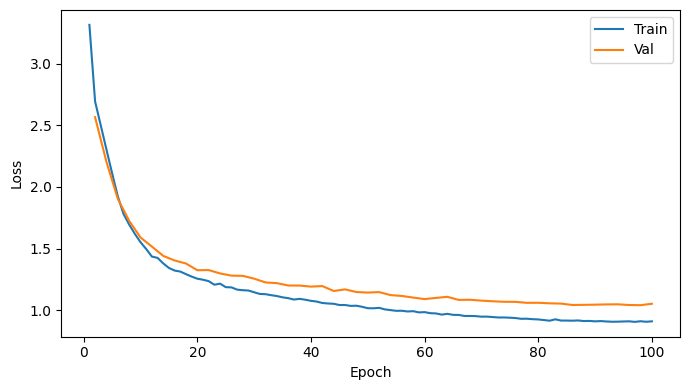

In [14]:
# Pretext loss 
ep = np.array(hist["epoch"], dtype=int)
tr = np.array(hist["train_loss"], dtype=float)
va = np.array(hist["val_loss"], dtype=float)

plt.figure(figsize=(7,4))
plt.plot(ep, tr, label="Train")
m = np.isfinite(va)
if m.any():
    plt.plot(ep[m], va[m], label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
plt.show()

In [15]:
# Linear Evaluation (clean)

BEST_ENC_PATH = Path(BEST_ENC_PATH) if not isinstance(BEST_ENC_PATH, Path) else BEST_ENC_PATH
BEST_CLS_PATH = Path(CKPT_SAVE_DIR) / "linear_cls_best.pth"  # save best linear head here

# -- Load best pretrained encoder (encoder-only) --
if BEST_ENC_PATH.exists():
    ck = torch.load(str(BEST_ENC_PATH), map_location=DEVICE)
    # allow either {"encoder": state_dict} or raw state_dict
    encoder.load_state_dict(ck["encoder"] if isinstance(ck, dict) and "encoder" in ck else ck)
    print(f"[info] Loaded encoder weights from {BEST_ENC_PATH.name}")
else:
    print(f"[warn] {BEST_ENC_PATH} not found; using current encoder in memory.")

# -- Freeze encoder (no gradients during linear eval) --
encoder.eval()
for p in encoder.parameters():
    p.requires_grad = False

# -- Linear classifier and optimizer (only classifier trains) --
classifier = nn.Linear(FEAT_DIM, num_classes).to(DEVICE)
opt_lin = torch.optim.AdamW(classifier.parameters(), lr=LR_LIN, weight_decay=1e-4)

# -- Eval helper: average CE loss + accuracy --
@torch.no_grad()
def eval_loss_acc(loader):
    encoder.eval(); classifier.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        feats  = encoder(x)               # frozen encoder
        logits = classifier(feats)
        total_loss += F.cross_entropy(logits, y, reduction="sum").item()
        correct    += (logits.argmax(1) == y).sum().item()
        total      += y.numel()
    return (total_loss / max(1, total)), (correct / max(1, total))

# -- Train loop (encoder frozen; grads flow only through classifier) --
lin_hist = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_acc, best_epoch, no_improve = 0.0, 0, 0

for epoch in range(1, EPOCHS_LIN + 1):
    encoder.eval(); classifier.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for x, y in train_cls_loader:
        x = x.to(DEVICE, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(DEVICE, non_blocking=True)

        opt_lin.zero_grad(set_to_none=True)
        # AMP for CUDA; encoder stays grad-free
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=torch.cuda.is_available()):
            with torch.no_grad():
                feats = encoder(x)        # truly frozen encoder
            logits = classifier(feats)
            loss   = F.cross_entropy(logits, y)

        loss.backward()
        opt_lin.step()

        running_loss += loss.item() * y.size(0)
        correct_train += (logits.argmax(1) == y).sum().item()
        total_train   += y.numel()

    # epoch metrics
    train_loss = running_loss / max(1, total_train)
    train_acc  = correct_train / max(1, total_train)
    val_loss, val_acc = eval_loss_acc(val_cls_loader)

    # log (store acc in % if you like for plotting)
    lin_hist["epoch"].append(epoch)
    lin_hist["train_loss"].append(train_loss)
    lin_hist["val_loss"].append(val_loss)
    lin_hist["train_acc"].append(train_acc * 100.0)
    lin_hist["val_acc"].append(val_acc * 100.0)

    print(f"[Linear {epoch:02d}] train: loss={train_loss:.4f}, acc={train_acc*100:.2f}% | "
          f"val: loss={val_loss:.4f}, acc={val_acc*100:.2f}%")

    # early stopping on best val acc
    if val_acc > best_val_acc + 1e-6:
        best_val_acc, best_epoch, no_improve = val_acc, epoch, 0
        torch.save(
            {"state_dict": classifier.state_dict(), "val_acc": best_val_acc, "epoch": best_epoch},
            str(BEST_CLS_PATH)
        )
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stop (patience reached).")
            break

print(f"Best Val Acc: {best_val_acc*100:.2f}% at epoch {best_epoch}")

[info] Loaded encoder weights from simclr_encoder_best.pth
[Linear 01] train: loss=0.3242, acc=90.86% | val: loss=0.2103, acc=93.07%
[Linear 02] train: loss=0.1870, acc=93.71% | val: loss=0.1879, acc=93.63%
[Linear 03] train: loss=0.1698, acc=94.30% | val: loss=0.1759, acc=94.00%
[Linear 04] train: loss=0.1600, acc=94.59% | val: loss=0.1665, acc=94.28%
[Linear 05] train: loss=0.1523, acc=94.90% | val: loss=0.1668, acc=94.28%
[Linear 06] train: loss=0.1458, acc=94.97% | val: loss=0.1614, acc=94.54%
[Linear 07] train: loss=0.1409, acc=95.22% | val: loss=0.1553, acc=94.61%
[Linear 08] train: loss=0.1368, acc=95.34% | val: loss=0.1523, acc=94.98%
[Linear 09] train: loss=0.1324, acc=95.51% | val: loss=0.1507, acc=95.00%
[Linear 10] train: loss=0.1287, acc=95.72% | val: loss=0.1465, acc=95.17%
[Linear 11] train: loss=0.1251, acc=95.73% | val: loss=0.1507, acc=95.02%
[Linear 12] train: loss=0.1231, acc=95.89% | val: loss=0.1440, acc=95.17%
[Linear 13] train: loss=0.1194, acc=95.93% | val: los

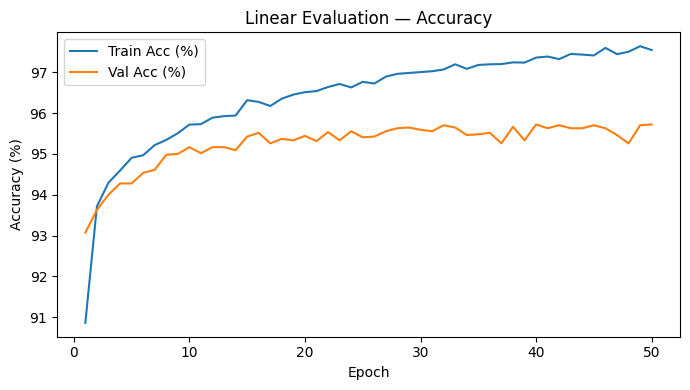

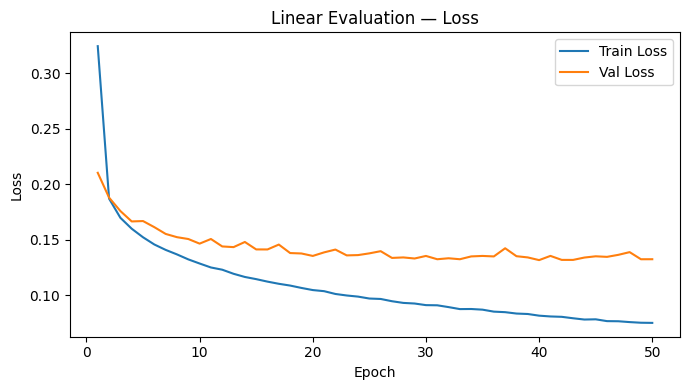

In [16]:
# Plots: Accuracy , Loss

plt.figure(figsize=(7,4))
plt.plot(lin_hist["epoch"], lin_hist["train_acc"], label="Train Acc (%)")
plt.plot(lin_hist["epoch"], lin_hist["val_acc"],   label="Val Acc (%)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Linear Evaluation — Accuracy")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(lin_hist["epoch"], lin_hist["train_loss"], label="Train Loss")
plt.plot(lin_hist["epoch"], lin_hist["val_loss"],   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Linear Evaluation — Loss")
plt.legend(); plt.tight_layout(); plt.show()


In [17]:
# Test Accuracy + Classification Report

# Load best linear head 
if BEST_CLS_PATH.exists():
    ck_cls = torch.load(str(BEST_CLS_PATH), map_location=DEVICE)
    classifier.load_state_dict(ck_cls["state_dict"])

encoder.eval(); classifier.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_cls_loader:
        imgs   = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        logits = classifier(encoder(imgs))
        preds  = logits.argmax(1)
        y_true.append(labels.cpu()); y_pred.append(preds.cpu())

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()
test_acc = (y_true == y_pred).mean() * 100.0
print(f"Final Test Accuracy: {test_acc:.2f}%")

# Pretty names from your earlier mapping
id2name = {v: k for k, v in classes.items()}
target_names = [id2name[i] for i in range(len(id2name))]
print("\nClassification Report (Test):")
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

Final Test Accuracy: 96.63%

Classification Report (Test):
                      precision    recall  f1-score   support

          AnnualCrop      0.976     0.943     0.959       300
              Forest      0.983     0.990     0.987       300
HerbaceousVegetation      0.942     0.967     0.954       300
             Highway      0.921     0.928     0.924       250
          Industrial      0.980     0.972     0.976       250
             Pasture      0.965     0.965     0.965       200
       PermanentCrop      0.956     0.948     0.952       250
         Residential      0.997     0.990     0.993       300
               River      0.937     0.952     0.944       250
             SeaLake      0.997     0.997     0.997       300

            accuracy                          0.966      2700
           macro avg      0.965     0.965     0.965      2700
        weighted avg      0.966     0.966     0.966      2700



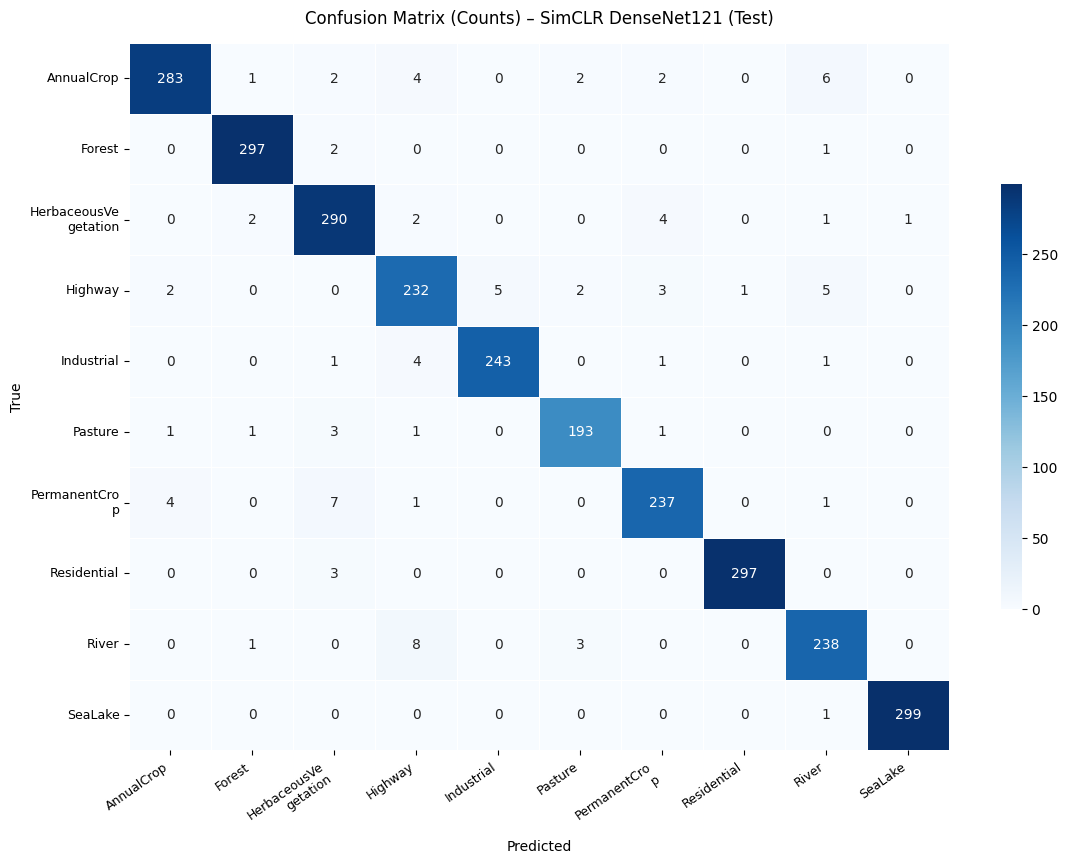

In [18]:
# =========================
# Confusion Matrix (mapped)
# =========================

class_names = [id2name[i] for i in range(num_classes)]

def _wrap(labels, width=12):
    import textwrap
    return ["\n".join(textwrap.wrap(str(s), width=width)) for s in labels]

wrapped = _wrap(class_names, width=12)

cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(12,9))
ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues",
                 cbar_kws={"shrink":0.6}, linewidths=0.5, linecolor="white")
ax.set_title("Confusion Matrix (Counts) – SimCLR DenseNet121 (Test)", pad=14)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticklabels(wrapped, rotation=35, ha="right", fontsize=9)
ax.set_yticklabels(wrapped, rotation=0,   va="center", fontsize=9)
plt.tight_layout(pad=2.0); plt.show()

saved /kaggle/working/simclr_densenet_gradcam_000.png


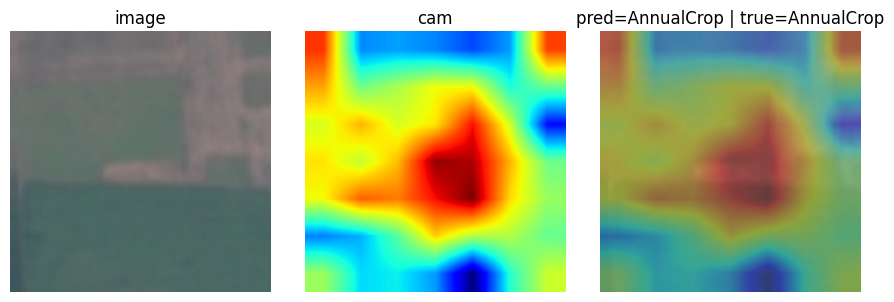

saved /kaggle/working/simclr_densenet_gradcam_001.png


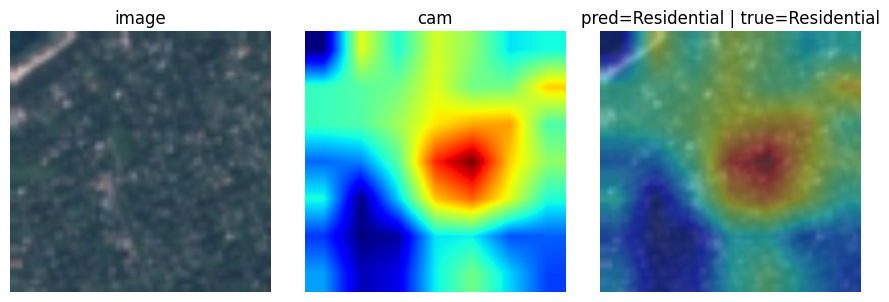

saved /kaggle/working/simclr_densenet_gradcam_002.png


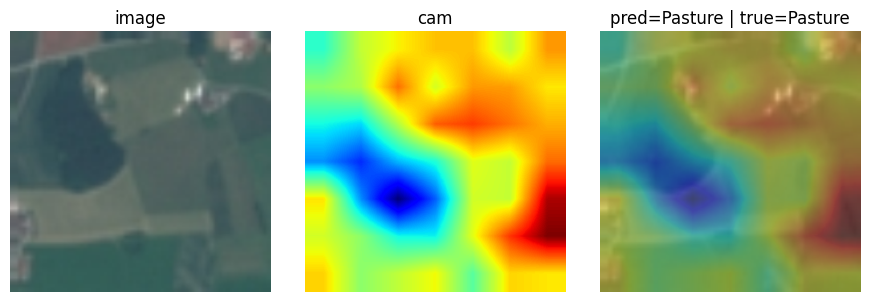

saved /kaggle/working/simclr_densenet_gradcam_003.png


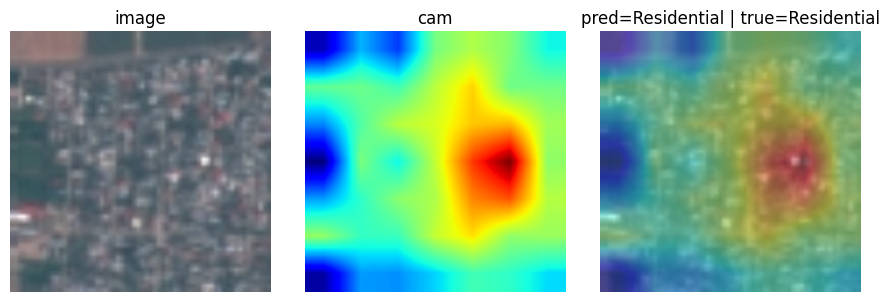

saved /kaggle/working/simclr_densenet_gradcam_004.png


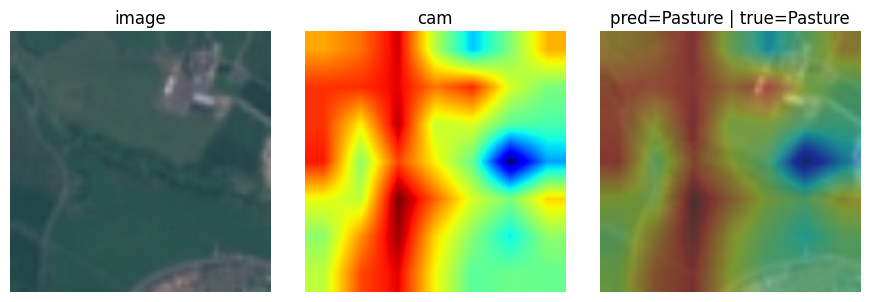

saved /kaggle/working/simclr_densenet_gradcam_005.png


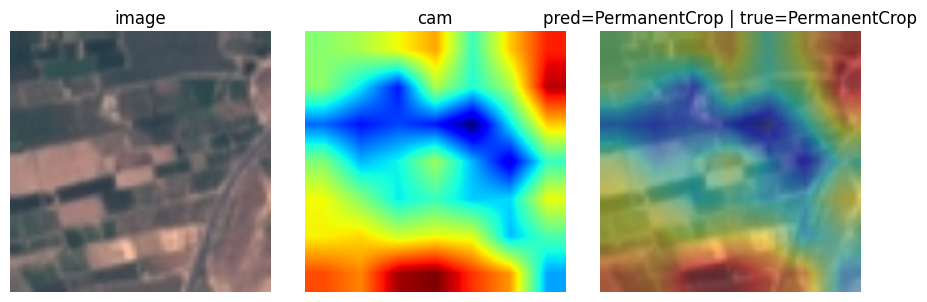

saved /kaggle/working/simclr_densenet_gradcam_006.png


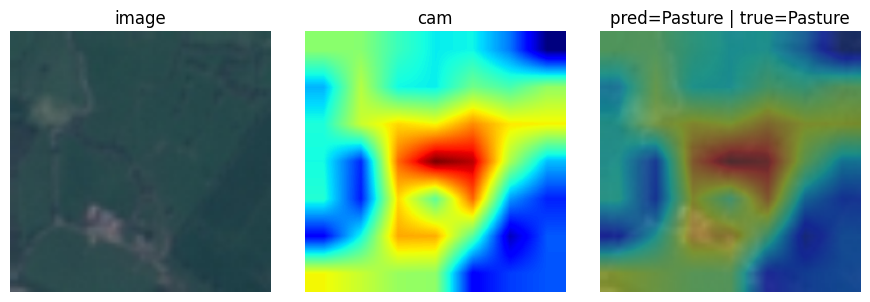

saved /kaggle/working/simclr_densenet_gradcam_007.png


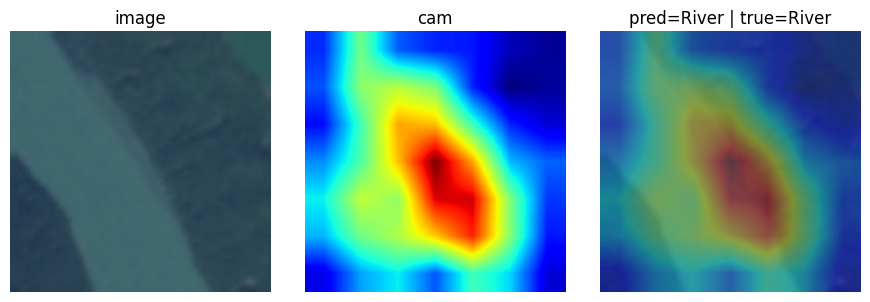

In [19]:
# ==========================================
# Grad-CAM (DenseNet-121 + linear head)
# ==========================================
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1,3,1,1)
def denorm(x: torch.Tensor) -> torch.Tensor:
    return (x * IMAGENET_STD + IMAGENET_MEAN).clamp(0, 1)

# DenseNet-feature maps 
class GradCAM_DenseNet:
    def __init__(self, encoder_densenet, linear_head):
        self.encoder = encoder_densenet
        self.head = linear_head
        self.encoder.eval(); self.head.eval()
        self.target_module = self.encoder.features   # conv stack output
        self._acts = None
        def fwd_hook(_, __, out):
            # out is conv feature map: [B, C, H, W]
            self._acts = out if not isinstance(out, (list, tuple)) else out[0]
            self._acts.retain_grad()
        self._h = self.target_module.register_forward_hook(fwd_hook)

    def remove(self):
        self._h.remove()

    def __call__(self, x: torch.Tensor, target_idx=None, use_relu=True):
        x = x.clone().detach().requires_grad_(True)
        feats = self.encoder(x)             # [B, FEAT_DIM]; hook fills self._acts
        if self._acts is None:
            raise RuntimeError("No activations captured at DenseNet.features")
        logits = self.head(feats)           # [B, num_classes]

        if target_idx is None:
            target_idx = logits.argmax(dim=1)
        else:
            target_idx = torch.as_tensor(target_idx, device=logits.device, dtype=torch.long).view(-1)

        scores = logits.gather(1, target_idx[:, None]).squeeze(1)

        self.encoder.zero_grad(set_to_none=True)
        self.head.zero_grad(set_to_none=True)
        scores.backward(torch.ones_like(scores), retain_graph=True)

        if self._acts.grad is None:
            raise RuntimeError("No gradients at target activations")

        grads = self._acts.grad                       # [B,C,H,W]
        acts  = self._acts                            # [B,C,H,W]
        weights = grads.mean(dim=(2,3), keepdim=True) # [B,C,1,1]
        cam = (weights * acts).sum(dim=1, keepdim=True)
        if use_relu:
            cam = cam.relu()

        # per-sample normalize
        B, _, H, W = cam.shape
        cam = cam.view(B, -1)
        cam = (cam - cam.min(dim=1, keepdim=True).values) / (cam.max(dim=1, keepdim=True).values - cam.min(dim=1, keepdim=True).values + 1e-8)
        cam = cam.view(B, 1, H, W)
        cam_up = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return cam_up.squeeze(1), target_idx

def overlay_cam(img: torch.Tensor, cam: torch.Tensor, alpha: float = 0.40):
    heat = plt.cm.jet(cam.detach().cpu().numpy())[:, :, :3]
    heat = torch.from_numpy(heat).permute(2,0,1).to(img.device, dtype=img.dtype)
    return ((1 - alpha) * img + alpha * heat).clamp(0,1)

def run_gradcam_simclr_densenet(
    encoder, classifier, loader,
    class_names,
    target_mode="true",      # "true" 
    num_batches=1, max_images=8,
    use_relu=False, alpha=0.40,
    save_dir="/kaggle/working"
):
    cam_engine = GradCAM_DenseNet(encoder, classifier)
    shown = 0
    for b, (x, y) in enumerate(loader):
        if b >= num_batches or shown >= max_images: break
        # গ্র্যাড লাগবে, তাই no_grad ব্যবহার করো না
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        target = y if target_mode == "true" else None
        cams, idxs = cam_engine(x, target_idx=target, use_relu=use_relu)
        x_den = denorm(x)

        for i in range(x.size(0)):
            if shown >= max_images: break
            img = x_den[i]; cam = cams[i]
            pred_i = int(idxs[i]); true_i = int(y[i])
            p_name = class_names[pred_i]
            t_name = class_names[true_i]

            ov = overlay_cam(img, cam, alpha=alpha)
            plt.figure(figsize=(9,3))
            plt.subplot(1,3,1); plt.imshow(to_pil_image(img.cpu())); plt.axis("off"); plt.title("image")
            plt.subplot(1,3,2); plt.imshow(cam.detach().cpu().numpy(), cmap="jet"); plt.axis("off"); plt.title("cam")
            plt.subplot(1,3,3); plt.imshow(to_pil_image(ov.cpu())); plt.axis("off"); plt.title(f"pred={p_name} | true={t_name}")
            plt.tight_layout()
            if save_dir:
                out = f"{save_dir}/simclr_densenet_gradcam_{shown:03d}.png"
                plt.savefig(out, dpi=150); print("saved", out)
            plt.show()
            shown += 1
    cam_engine.remove()

# ---- Run Grad-CAM (after test eval) ----
class_names = [id2name[i] for i in range(num_classes)]
run_gradcam_simclr_densenet(
    encoder=encoder,           # DenseNet-121 (classifier=Identity)
    classifier=classifier,     # trained linear head
    loader=test_cls_loader,
    class_names=class_names,
    target_mode="true",        # true-class explain
    num_batches=2,
    max_images=8,
    use_relu=False,
    alpha=0.40,
    save_dir="/kaggle/working"
)


In [20]:
# t-SNE utilities 

@torch.no_grad()
def extract_features(encoder, loader, device):
    encoder.eval()
    feats, labels = [], []
    for imgs, y in loader:
        imgs = imgs.to(device, non_blocking=True)
        out = encoder(imgs)
        if isinstance(out, (list, tuple)): out = out[0]
        feats.append(out.detach().cpu())
        labels.append(torch.as_tensor(y).detach().cpu())
    X = torch.cat(feats).numpy()
    y = torch.cat(labels).numpy()
    return X, y

def tsne_plot_3d(X, y, title, save_html=None, n_samples=2000):
    # sample for responsiveness
    if X.shape[0] > n_samples:
        idx = np.random.RandomState(42).choice(X.shape[0], n_samples, replace=False)
        X, y = X[idx], y[idx]
    # auto perplexity in a safe range
    perplexity = min(30, max(5, (int(X.shape[0]) - 1)//4))
    X_emb = TSNE(n_components=3, perplexity=perplexity, init="pca",
                 random_state=42, learning_rate="auto").fit_transform(X)
    fig = px.scatter_3d(x=X_emb[:,0], y=X_emb[:,1], z=X_emb[:,2],
                        color=y.astype(str), title=title, labels={"color":"label"})
    if save_html:
        fig.write_html(save_html)
        print(f"[t-SNE] saved -> {save_html}")
    fig.show()
    return fig

In [21]:
# Silhouette helper (cosine) 

def silhouette_cosine_from_embeddings(X, y, max_n=2000):
 
    # Convert to arrays
    X = np.asarray(X)
    y = np.asarray(y)

    # Need at least 2 classes and ≥2 samples/class
    uniq, counts = np.unique(y, return_counts=True)
    if len(uniq) < 2 or counts.min() < 2:
        return None  # not computable

    # L2-normalize for cosine distance
    X = normalize(X, norm="l2", axis=1)


    # Compute silhouette with cosine distance
    try:
        score = silhouette_score(X, y, metric="cosine")
        return float(score)
    except Exception:
        return None

# TRAIN  
X_tr, y_tr = extract_features(encoder, train_cls_loader, DEVICE)
s_tr = silhouette_cosine_from_embeddings(X_tr, y_tr, max_n=2000)
title_tr = f"3D t-SNE (Train) — Silhouette(cos): {s_tr:.3f}" if s_tr is not None else "3D t-SNE (Train) — Silhouette: N/A"
_ = tsne_plot_3d(X_tr, y_tr, title_tr, save_html="/kaggle/working/tsne3d_train.html")
print(f"Train silhouette (cosine): {s_tr:.3f}" if s_tr is not None else "Train silhouette: N/A")


# TEST
X_te, y_te = extract_features(encoder, test_cls_loader, DEVICE)
s_te = silhouette_cosine_from_embeddings(X_te, y_te, max_n=2000)
title_te = f"3D t-SNE (Test) — Silhouette(cos): {s_te:.3f}" if s_te is not None else "3D t-SNE (Test) — Silhouette: N/A"
_ = tsne_plot_3d(X_te, y_te, title_te, save_html="/kaggle/working/tsne3d_test.html")
print(f"Test silhouette (cosine): {s_te:.3f}" if s_te is not None else "Test silhouette: N/A")

# =========================
# ======== (OPTIONAL) =====
# =========  VAL ==========
# =========================
# Uncomment if you also want validation
# X_val, y_val = extract_features(encoder, val_cls_loader, DEVICE)
# s_val = silhouette_cosine_from_embeddings(X_val, y_val, max_n=2000)
# title_val = f"3D t-SNE (Val) — Silhouette(cos): {s_val:.3f}" if s_val is not None else "3D t-SNE (Val) — Silhouette: N/A"
# _ = tsne_plot_3d(X_val, y_val, title_val, save_html="/kaggle/working/tsne3d_val.html")
# print(f"Val silhouette (cosine): {s_val:.3f}" if s_val is not None else "Val silhouette: N/A")

[t-SNE] saved -> /kaggle/working/tsne3d_train.html


Train silhouette (cosine): 0.286
[t-SNE] saved -> /kaggle/working/tsne3d_test.html


Test silhouette (cosine): 0.305
